In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.io
import tensorflow as tf

In [4]:
# rnn parameters
epoch = 100
batch = 32
lookback =  72    
feature = 1    
num_units = 50

In [24]:
# read cgm values
df = pd.read_csv('./CGMProcessed.csv')
data_preprocessed=list(df['numCGM'])

Mean of dataset:  147.70255007327796


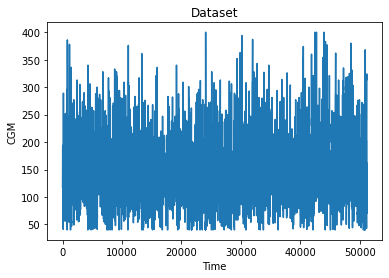

In [25]:
# analyze cgm data
data_preprocessed = np.nan_to_num(data_prepocessed).astype('int64')
train_size = int((len(data_preprocessed))*0.8)
test_size = int((len(data_preprocessed))*0.2 )
final_data = data_preprocessed[0:(train_size + test_size),:]
print("Mean of dataset: ",final_data.mean())
plt.plot(final_data)
plt.title('Dataset')
plt.xlabel('Time')
plt.ylabel('CGM')
plt.show()

In [28]:
# get train and test set

from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(0,1),copy=True) 
data_scaled = scaling.fit_transform(final_data,y=None) 

train_set = data_scaled[0:train_size,:]
test_set = data_scaled[train_size:(train_size + test_size),:]

xtrain = []
ytrain = []
for i in range(lookback,train_size):
    xtrain.append(data_scaled[i-lookback:i,0])
    ytrain.append(data_scaled[i,0])
    
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

xtest = []
ytest = []
for i in range(lookback,(lookback + test_size)):
    xtest.append(data_scaled[i-lookback:i,0])
    ytest.append(data_scaled[i,0])
    
xtest = np.array(xtest)
ytest = np.array(ytest)

xtrain = np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],feature))
xtest = np.reshape(xtest,(xtest.shape[0],xtest.shape[1],feature))



In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import losses
from keras import optimizers

In [32]:
# build LSTM and train

reg_obj = Sequential()

reg_obj.add(LSTM(units = num_units,return_sequences= True,input_shape = (xtrain.shape[1],1)))
reg_obj.add(Dropout(0.2))

reg_obj.add(LSTM(units = num_units, return_sequences= True))
reg_obj.add(Dropout(0.2))

reg_obj.add(LSTM(units = num_units,return_sequences= True))
reg_obj.add(Dropout(0.2))

reg_obj.add(LSTM(units = num_units))
reg_obj.add(Dropout(0.2))

reg_obj.add(Dense(units = 1))

opt = tf.keras.optimizers.Adam(clipvalue=0.5)
reg_obj.compile(optimizer = opt, loss = losses.mean_squared_error)

reg_obj.fit(xtrain, ytrain, epochs = epoch, batch_size = batch)

Epoch 1/100
1278/1278 [==============================] - 83s 61ms/step - loss: 0.0042
Epoch 2/100
1278/1278 [==============================] - 81s 63ms/step - loss: 0.0012
Epoch 3/100
1278/1278 [==============================] - 81s 63ms/step - loss: 8.5349e-04
Epoch 4/100
1278/1278 [==============================] - 81s 63ms/step - loss: 7.3656e-04
Epoch 5/100
1278/1278 [==============================] - 79s 62ms/step - loss: 7.1683e-04
Epoch 6/100
1278/1278 [==============================] - 84s 66ms/step - loss: 7.0082e-04
Epoch 7/100
1278/1278 [==============================] - 81s 63ms/step - loss: 6.5705e-04
Epoch 8/100
1278/1278 [==============================] - 81s 63ms/step - loss: 6.5709e-04
Epoch 9/100
1278/1278 [==============================] - 81s 63ms/step - loss: 6.3113e-04
Epoch 10/100
1278/1278 [==============================] - 84s 65ms/step - loss: 6.2582e-04
Epoch 11/100
1278/1278 [==============================] - 82s 64ms/step - loss: 6.2219e-04
Epoch 12/100
127

1278/1278 [==============================] - 80s 62ms/step - loss: 5.0280e-04
Epoch 92/100
1278/1278 [==============================] - 79s 62ms/step - loss: 5.0787e-04
Epoch 93/100
1278/1278 [==============================] - 79s 62ms/step - loss: 5.0559e-04
Epoch 94/100
1278/1278 [==============================] - 79s 62ms/step - loss: 4.8849e-04
Epoch 95/100
1278/1278 [==============================] - 79s 62ms/step - loss: 5.0030e-04
Epoch 96/100
1278/1278 [==============================] - 79s 62ms/step - loss: 4.9258e-04
Epoch 97/100
1278/1278 [==============================] - 80s 62ms/step - loss: 5.0601e-04
Epoch 98/100
1278/1278 [==============================] - 80s 63ms/step - loss: 4.9594e-04
Epoch 99/100
1278/1278 [==============================] - 80s 62ms/step - loss: 5.0218e-04
Epoch 100/100
1278/1278 [==============================] - 80s 63ms/step - loss: 4.9613e-04


In [34]:
# get the predicted values for train and test set
predicted_train = reg_obj.predict(xtrain)
predicted_test = reg_obj.predict(xtest)

predict_train_final = scaling.inverse_transform(predicted_train)
ytrain_shape = ytrain.reshape(-1,1)
train_y_final = scaling.inverse_transform(ytrain_shape)
predict_test_final = scaling.inverse_transform(predicted_test)
ytest_shape = ytest.reshape(-1,1)
test_y_final = scaling.inverse_transform(ytest_shape)

In [35]:
from math import sqrt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

Train Value: 6.72 RMSE
Test Value: 6.89 RMSE
Mean of dataset:  147.70255007327796


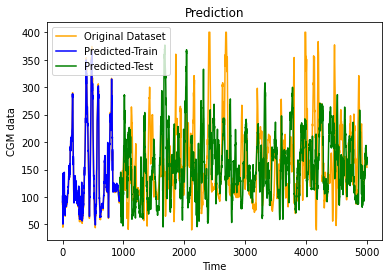

In [36]:
# get rmse  and plot predicted train, predicted test, and original dataset values for CGM

train_value = sqrt(mean_squared_error(train_y_final,predict_train_final))
test_value = sqrt(mean_squared_error(test_y_final,predict_test_final))

print('Train Value: %.2f RMSE' % (train_value))
print('Test Value: %.2f RMSE' % (test_value))
print("Mean of dataset: ",final_data.mean())

plot_train = np.empty_like(final_data,dtype=np.double)
plot_train[:, :] = np.NaN
plot_train[lookback:len(predict_train_final)+lookback, :] = predict_train_final

plot_test = np.empty_like(final_data,dtype=np.double)
plot_test[:, :] = np.NaN
plot_test[len(predicted_train)+lookback:len(final_data), :] = predict_test_final


plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('CGM data')
plt.plot(final_data[40000:45000], color = 'orange', label = 'Original Dataset')
plt.plot(plot_train[40000:45000], color = 'blue', label = 'Predicted-Train')
plt.plot(plot_test[40000:45000], color = 'green', label = 'Predicted-Test')
plt.legend()
plt.show()